<h3 style="text-align: center;"><b>Generative adversarial networks. Cycle GAN</b></h3>

Выполнила: **Екатерина Кусакина, Stepik ID: 187218479**

In [1]:
import os
import itertools
import time
import datetime
import sys
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision.transforms as tt
import torch
import torch.nn as nn
from torchvision.utils import save_image, make_grid
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from PIL import Image

## Введение. Что такое Cycle GAN?

CycleGAN — это тип генеративно-состязательной сети, используемой для переноса стиля изображения. 

Обычно CycleGAN применяют для изменения стиля фотографий. Например:
* изменение времени суток (день на ночь, ночь на день)
* изменение времени года (зима на лето, лето на осень и т.д.)
* создание фотореалистичных изображений по контурам 
* добавление или удаление элементов на фото (добавим деревья, уберем людей и т.п.)
* преобразование черно-белых фото в цветные

CycleGAN позволяет реализовать обучение на независимых множествах т.е для ее обучения не нужны парные наборы данных. Достаточно предоставить сети два датасета с фотографиями, стиль одного из которых мы ходим перенести на другой. Размеры датасетов могут отличаться. 

Архитектура CycleGAN представляет собой 2 генератора и 2 дискриминатора, которые выполняют следующие задачи:
* Генератор GA учится преобразовывать исходное изображение X в выходное изображение Y
* Генератор GB учится преобразовывать выходное изображение Y в исходное изображение X
* Дискриминатор DA учится различать изображение X и сгенерированное изображение X(GB(Y))
* Дискриминатор DB учится различать изображение Y и сгенерированное изображение Y(GA(X))

Сcылки на материалы, использованные в работе:

* https://medium.com/analytics-vidhya/the-beauty-of-cyclegan-c51c153493b8
* https://neerc.ifmo.ru/wiki/index.php?title=%D0%97%D0%B0%D0%B4%D0%B0%D1%87%D0%B0_%D1%82%D1%80%D0%B0%D0%BD%D1%81%D0%BB%D1%8F%D1%86%D0%B8%D0%B8_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9
* https://arxiv.org/pdf/1703.10593.pdf   
* https://github.com/junyanz/CycleGAN/blob/master/models/cycle_gan_model.lua
* https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/issues/39
* https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html


## Часть 1. Подготовка данных

В качестве обучающей выборки возьмем датасет [Monet2Photo](https://www.kaggle.com/balraj98/monet2photo), который содержит изображения картин Клода Моне и фотографии природы.

In [ ]:
@inproceedings
{CycleGAN2017,
  title={Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks},
  author={Zhu, Jun-Yan and Park, Taesung and Isola, Phillip and Efros, Alexei A},
  booktitle={Computer Vision (ICCV), 2017 IEEE International Conference on},
  year={2017}
}

Поскольку обучение Cycle GAN требует значительных ресурсов, будем преобразовывать размер картин к 128 х 128, чтобы сократить время обучения.

In [2]:
# Поместим распакованный датасет в папку "archive"
DATA_DIR = 'archive/'

In [3]:
image_size = 256
# image_size = 128
batch_size = 1
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [4]:
# Считаем файл metadata.csv, содержащий пути к картинам(trainA, testA) и фотографиям (trainB, testB) 
df = pd.read_csv(''.join([DATA_DIR, 'metadata.csv']))
df

,image_id,domain,split,image_path
0,00001,A (Monet Painting),train,trainA/00001.jpg
1,00003,A (Monet Painting),train,trainA/00003.jpg
2,00004,A (Monet Painting),train,trainA/00004.jpg
3,00006,A (Monet Painting),train,trainA/00006.jpg
4,00007,A (Monet Painting),train,trainA/00007.jpg
...,...,...,...,...
8226,2017-01-03 07_00_30,B (Photo),train,trainB/2017-01-03 07_00_30.jpg
8227,2017-01-03 07_18_12,B (Photo),train,trainB/2017-01-03 07_18_12.jpg
8228,2017-01-03 08_19_17,B (Photo),train,trainB/2017-01-03 08_19_17.jpg
8229,2017-01-03 09_23_19,B (Photo),train,trainB/2017-01-03 09_23_19.jpg


In [5]:
df.describe()

,image_id,domain,split,image_path
count,8231,8231,8231,8231
unique,8231,2,2,8231
top,00001,B (Photo),train,trainA/00001.jpg
freq,1,7038,7359,1


In [6]:
img = Image.open(''.join([DATA_DIR, 'testB/2014-08-01 17_41_55.jpg'])).convert('LA')
img
img.size

(256, 256)

In [7]:
# Формируем тренировочные и тестовые numpy-массивы, содержащие пути к изображениям картин и фотографиям
train_A_arr = df[(df['split'] == 'train') & (df['domain'] == 'A (Monet Painting)')]['image_path'].values #1072
train_B_arr = np.append(list(map(lambda s: s.replace('trainA' , 'trainB'), train_A_arr[1072:])), 
                        df[(df['split'] == 'train') & (df['domain'] == 'B (Photo)')]['image_path'].values)
train_A_arr = train_A_arr[:1072]

test_B_arr = df[(df['split'] == 'test') & (df['domain'] == 'B (Photo)')]['image_path'].values
test_A_arr = np.array(list(map(lambda s: s.replace('testB' , 'testA'), test_B_arr[:121]))) 
test_B_arr = test_B_arr[121:]

Длина массива test_B_arr равна 872 адреса, в то время как в папке testB всего 751 изображение. Выберем только адреса тех фото, которые есть в папке:

In [8]:
# Количество фотографий в train_B примерно в 5 раз превышает количество изображений картин в train_А, 
# поэтому размер батча для train_B будет 5, для train_А - 1.
batch_size_B = train_B_arr.shape[0]//train_A_arr.shape[0]
batch_size_B

5

In [9]:
num_workers = 0

transform=tt.Compose([
    #     меняем размер на 128х128
#         tt.Resize(image_size),
        tt.ToTensor(),
    #     нормализуем изображение
        tt.Normalize(*stats)])

def image2tensor(image):
    return transform(image) #.float()

def get_dl(arr, batch_size=batch_size):
    images_number = arr.shape[0]
    ds = torch.empty(size=(images_number, 3, image_size, image_size))
    j = 0
    for path_to_img in arr:
        image_temp = Image.open(''.join([DATA_DIR, path_to_img])).convert('RGB') 
        ds[j] = image2tensor(image_temp)
        j += 1
    dl = DataLoader(ds, batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    return dl
# Формируем data loaders, загружая изображения и преобразовывая их в тензоры 
trainA_dl = get_dl(train_A_arr)
trainB_dl = get_dl(train_B_arr)
# trainB_dl = get_dl(train_B_arr, batch_size_B)
testA_dl = get_dl(test_A_arr, 5)
testB_dl = get_dl(test_B_arr, 5)

In [10]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images in dl:
        show_images(images, nmax)
        break

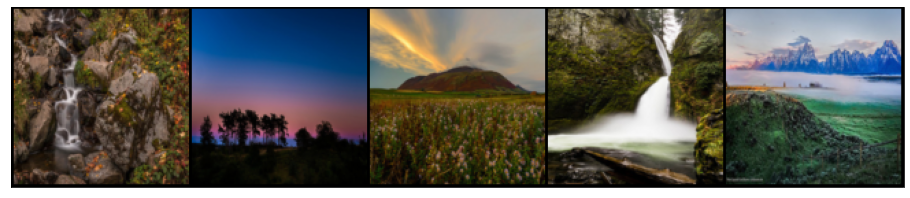

In [11]:
# Посмотрим, как выглядят изображения в одном батче
show_batch(trainB_dl)

## Часть 2. Построение и обучение модели

## **Архитектуры генераторов и дискриминаторов**

**Генераторы**

Оба генератора имеют одну и ту же архитектуру: 
   
&emsp;1) downsampling (понижение размерности): c7s1-64, d128, d256, 
   
&emsp;2) residual_blocks: R256 * num_residual_blocks,
   
&emsp;3) upsampling: u128, u64, c7s1-3, 

где:
 * c7s1-k обозначает 7×7 Convolution-InstanceNorm-ReLU с k фильтрами и шагом 1. Эти блоки используются как основа сверточных вычислений в генераторе;
 * dk обозначает 3×3 Convolution-InstanceNorm-ReLU с k фильтрами и шагом 2. Блоки dk используются для уменьшения размера свертки в два раза;
 * Rk обозначает residual block, который содержит два сверточных слоя 3×3 с k фильтрами на каждом слое. Блоки Rk используются для рекуррентных соединений в «скрытом пространстве» генератора;
 * num_residual_blocks обозначает количество residual blocks; для изображений с разрешением 256х256 и выше используется архитектура с 9-ю  residual blocks, для изображений 128х128 - с 6-ю  residual blocks; 
 * uk обозначает 3 × 3 ConvTranspose2d-InstanceNorm-ReLU с фильтрами k и шагом 2. Блоки uk являются обратными для блоков dk, так как они увеличивает разрешение изображения в два раза.


**Дискриминатор**

Оба дискриминатора имеют одну и ту же архитектуру: C64-C128-C256-C512, 

где Ck - это слой Convolution-InstanceNorm-LeakyReLU 4 × 4 с k фильтрами и шагом 2. В C64 нет InstanceNorm. 

Такая архитектура называется PatchGAN 70×70. Разница между PatchGAN и обычным дискриминатором GAN заключается в том, что обычный GAN сопоставляет изображение 256x256 с одним скалярным выходом, который означает «настоящий» или «поддельный», тогда как PatchGAN сопоставляет 256x256 с массивом NxN выходов X, где каждый X_ij означает, является ли патч ij на изображении реальным или поддельным. Как понять, какой патч ij на входе? По выходному нейрону X_ij мы можем отследить ту часть входного изображения, которой он соответствует. 

Математически эквивалентно тому, если бы мы вручную нарезали входное изображение на перекрывающиеся участки размером 70x70, запускали обычный дискриминатор над каждым участком и усредняли результаты.



In [11]:
n_residual_blocks = 9 if image_size > 128 else 6 #количество residual blocks в генераторе

# Инициализация весов нормальным распределением
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
         
# Класс для отладки - распечатки размеров слоев модели    
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        print(x.shape)
        return x
    
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.downsampling = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 64, kernel_size=7, stride=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
                      
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)    
        )
        
        self.residual_block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, kernel_size=3),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(256, 256, kernel_size=3),
            nn.InstanceNorm2d(256),
        )

        self.upsampling = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # torch.Size([1, 128, 32, 32])
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), #torch.Size([1, 64, 32, 32])
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, kernel_size=7, stride=1), #torch.Size([1, 3, 128, 128])
            nn.Tanh()
        ) 

    def forward(self, x, n_residual_blocks=n_residual_blocks):
        x = self.downsampling(x)         
        for _ in range(n_residual_blocks):
            x = self.residual_block(x)
        x = self.upsampling(x)                
        return x 

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Вычисляем выходной размер изображения в дискриминаторе (PatchGAN)
        self.output_shape = (1, image_size // (2 ** 4), image_size // (2 ** 4))

        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1), 
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
                      
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
                      
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
                      
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )        
        
    def forward(self, img):

        return self.model(img)

In [17]:
# Отладочная функция для распечатывания размеров слоев модели
def print_sizes(model, input_tensor):
    output = input_tensor
    for m in model.children():
        output = m(output)
        print(m, output.shape)
    return output

one_batch = next(iter(trainA_dl))

print_sizes(model = G_AB, input_tensor= one_batch.to(device))


Sequential(
  (0): ReflectionPad2d((3, 3, 3, 3))
  (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
  (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (3): ReLU(inplace=True)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (9): ReLU(inplace=True)
) torch.Size([1, 256, 32, 32])
Sequential(
  (0): ReflectionPad2d((1, 1, 1, 1))
  (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (3): ReLU(inplace=True)
  (4): ReflectionPad2d((1, 1, 1, 1))
  (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (6): InstanceNorm2d(256, eps=1e-05

tensor([[[[-0.1702,  0.3371, -0.1334,  ..., -0.2781, -0.1454,  0.1529],
          [ 0.0195, -0.1054, -0.2573,  ..., -0.0468,  0.2276, -0.2340],
          [-0.0080, -0.0535, -0.2179,  ...,  0.0269, -0.0658, -0.2007],
          ...,
          [ 0.2966, -0.0157,  0.1343,  ...,  0.0202,  0.3531,  0.0186],
          [-0.1615, -0.2963,  0.0750,  ...,  0.0639,  0.0327, -0.0198],
          [-0.1217, -0.2851, -0.0227,  ...,  0.1061,  0.0560,  0.0327]],

         [[-0.1355, -0.0326,  0.2569,  ...,  0.1131,  0.1713,  0.1298],
          [ 0.5217, -0.0702,  0.2589,  ..., -0.0257,  0.2028,  0.0862],
          [ 0.1656,  0.1789,  0.1494,  ...,  0.0729,  0.3662,  0.0754],
          ...,
          [ 0.0687,  0.0331,  0.1374,  ...,  0.2473,  0.1448, -0.1014],
          [ 0.1305,  0.1471,  0.1148,  ...,  0.1899,  0.2398,  0.1690],
          [ 0.5209,  0.2961,  0.4865,  ...,  0.0651,  0.2485,  0.0020]],

         [[ 0.2848, -0.1680,  0.0858,  ...,  0.0284, -0.0997, -0.1454],
          [ 0.1193,  0.1189,  

In [12]:
# Создаем папку для хранения сгенерированных изображений
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

# Создаем папку для хранения параметров обученной модели
sample_model = 'models'
os.makedirs(sample_model, exist_ok=True)

In [13]:
# Функция для сохранения параметров модели в процессе обучения

def save_checkpoint(state, filename='./models/checkpoint.pth.tar'):
    filename = './models/checkpoint_{}.pth.tar'.format(filename)
    torch.save(state, filename)  

## Функции потерь (лоссы) в Cycle GAN 

### Лосс генераторов

Лосс генераторов состоит из трёх лоссов: 

**1) Adversarial loss** измеряет, насколько близок к 1 результат работы дискриминатора для реальных изображений log Dy(y)), 
и насколько близко к 0 результат работы дискриминатора для поддельных изображений log(1-Dy(G(x))).

В коде, на который ссылается статья https://arxiv.org/pdf/1703.10593.pdf и который написан на lua 
(https://github.com/junyanz/CycleGAN/blob/master/models/cycle_gan_model.lua), 
в качестве adversarial loss используется nn.BCECriterion() или nn.MSECriterion(). В лекции по GAN-ам упоминалось, 
что MSE работает лучше, поэтому используем его. 

**2), 3) Cycle loss, identity loss**: в коде, на который ссылается статья https://arxiv.org/pdf/1703.10593.pdf и который написан на Lua/Torch 
(https://github.com/junyanz/CycleGAN/blob/master/models/cycle_gan_model.lua), 
в качестве cycle loss и  identity loss используется nn.AbsCriterion(). Согласно документации он "создает критерий, 
измеряющий среднее абсолютное значение между n элементами входных данных x и выходных данных y". 
В torch таким лоссом является torch.nn.L1Loss(), поэтому используем его.

Итого, у нас есть 4 лосса: два adversarial loss (по одному для каждого дискриминатора), сycle loss и identity loss. Однако, эти лоссы не одинаково важны. И, чтобы решить эту проблему, авторы вводят коэффициент λ, равный 10.  
В финальном уравнении потерь для генератора сycle loss умножается на λ, identity loss - на 0,5 * λ, и только потом все 4 лосса суммируются.

### Лосс дискриминаторов
В качестве лосса для дискриминаторов используется описанный выше adversarial loss.

In [14]:
# Определение лоссов  и помещение их в GPU
adversarial_loss = torch.nn.MSELoss()
cycle_loss = torch.nn.L1Loss()
identity_loss = torch.nn.L1Loss()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

adversarial_loss.to(device)
cycle_loss.to(device)
identity_loss.to(device)

lambda_cyc = 10.0 # вес cycle loss
lambda_id  = 0.5 * lambda_cyc # вес identity loss

In [ ]:
# Инициализация генератора и дискриминатора и помещение их в GPU
# input_shape = (3, image_size, image_size)
G_AB = Generator()
G_BA = Generator()
D_A = Discriminator()
D_B = Discriminator()

G_AB = G_AB.to(device)
G_BA = G_BA.to(device)
D_A = D_A.to(device)
D_B = D_B.to(device)

In [ ]:
# Инициализация весов нормальным распределением
G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)

In [20]:
# Класс для понижения lr(learning rate); 
# Если, например, учим 200 эпох, то с 100-й эпохи lr будет линейно снижаться
class Lambda_rule:
    def __init__(self, n_epochs, start_epoch, decay_epoch):
        assert (n_epochs - decay_epoch) > 0, "Понижение lr должно начаться до окончания обучения"
        self.n_epochs = n_epochs
        self.start_epoch = start_epoch
        self.decay_epoch = decay_epoch

    def step(self, epoch):
        return 1.0 - max(0, self.start_epoch + epoch - self.decay_epoch) / (self.n_epochs - self.decay_epoch)

In [21]:
# Оптимизаторы

n_epochs = 100 # количество эпох
start_epoch = 0 # эпоха, с которой начинается обучение
epoch = 0 # текущая эпоха
decay_epoch = n_epochs // 2 # номер эпохи, с которой начинается понижение lr(learning rate)
lr = 0.0002
b1 = 0.5 
b2 = 0.999 

optimizer_G = torch.optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1, b2))
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(b1, b2))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(b1, b2))


# Schedulers для обновления скорости обучения (lr) 
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G, lr_lambda=Lambda_rule(n_epochs, epoch, decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_A, lr_lambda=Lambda_rule(n_epochs, epoch, decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_B, lr_lambda=Lambda_rule(n_epochs, epoch, decay_epoch).step)

In [39]:
# Функция для сохранения оригинальных и генерируемых изображений в процессе обучения
def sample_images(batches_done):
    imgs_A  = next(iter(testA_dl)) 
    imgs_B  = next(iter(testB_dl))
    G_AB.eval()
    G_BA.eval()
    real_A = Variable(imgs_A.to(device))
    fake_B = G_AB(real_A)
    real_B = Variable(imgs_B.to(device))
    fake_A = G_BA(real_B)
    # Выстраиваем изображения вдоль оси х
    real_A = make_grid(real_A, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    # Реальная картина, фейковое фото, реальное фото, фейковая картина
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    save_image(image_grid, "generated/{}.png".format(batches_done), normalize=False)

In [23]:
# Функция для сохранения лоссов для последующего вывода их на графики
import pandas as pd

def save_loss(file_name, losses_g, losses_d):
    df = pd.DataFrame({'losses_g' : losses_g, 'losses_d' : losses_d} ) 
    df.to_csv(file_name, sep = ';', index=False)

In [ ]:
#  Обучение

# Начальная эпоха для расчета количества эпох при сохранении промежуточного состояния моделей и оптимизаторов
# start_epoch = 0 
save_models_interval = 10 # интервал (в эпохах), через который сохраняется промежуточное состояние моделей и оптимизаторов
sample_interval = 100 # интервал (в батчах), через который сохраняются сгенерированные изображения

prev_time = time.time()

# Массивы для хранения лоссов
losses_g = []
losses_d = []

for epoch in range(epoch, n_epochs):
    i = 0
    loss_g_per_epoch = []
    loss_d_per_epoch = []
    for batch_A, batch_B in zip(trainA_dl, trainB_dl):

        real_A = Variable(batch_A.to(device)) #torch.Size([1, 3, 128, 128])
        real_B = Variable(batch_B.to(device)) #torch.Size([5, 3, 128, 128])
        
        # Создаем тензоры с метками 0 и 1
        valid = torch.ones((real_A.size(0), *D_A.output_shape), device=device)
        fake = torch.zeros((real_A.size(0), *D_A.output_shape), device=device)

        # Обучение генераторов
        G_AB.train()
        G_BA.train()

        optimizer_G.zero_grad()

        # Вычисляем Identity loss
        loss_id_A = identity_loss(G_BA(real_A), real_A)
        loss_id_B = identity_loss(G_AB(real_B), real_B)
        loss_identity = (loss_id_A + loss_id_B) / 2

        # Вычисляем Adversarial loss
        # Получили фейковое фото из картины: G(A)-> fake B
        fake_B = G_AB(real_A)
        # fake photo vs 1
        loss_adversarial_AB = adversarial_loss(D_B(fake_B), valid)
        # Получили фейковую картину из фото:  G(B) -> fake A
        fake_A = G_BA(real_B)
        # fake monet vs 1 
        loss_adversarial_BA = adversarial_loss(D_A(fake_A), valid)
        
        loss_adversarial = (loss_adversarial_AB + loss_adversarial_BA) / 2

        # Вычисляем Cycle loss
        recov_A = G_BA(fake_B)
        cycle_loss_A = cycle_loss(recov_A, real_A)
        recov_B = G_AB(fake_A)
        cycle_loss_B = cycle_loss(recov_B, real_B)
        loss_cycle = (cycle_loss_A + cycle_loss_B) / 2

        # Вычисляем итоговый лосс генераторов
        loss_G = loss_adversarial + lambda_cyc * loss_cycle + lambda_id * loss_identity

        loss_G.backward()
        optimizer_G.step()
        
        loss_g_per_epoch.append(loss_G.item())

        # Обучение дискриминатора A

        optimizer_D_A.zero_grad()

        loss_real = adversarial_loss(D_A(real_A), valid)        
        loss_fake = adversarial_loss(D_A(fake_A.detach()), fake)
        # Вычисляем лосс дискриминатора A
        loss_D_A = (loss_real + loss_fake) / 2

        loss_D_A.backward()
        optimizer_D_A.step()

        # Обучение дискриминатора B

        optimizer_D_B.zero_grad()

        loss_real = adversarial_loss(D_B(real_B), valid)
        loss_fake = adversarial_loss(D_B(fake_B.detach()), fake)
        # Вычисляем лосс дискриминатора B
        loss_D_B = (loss_real + loss_fake) / 2
        
        loss_D_B.backward()
        optimizer_D_B.step()
        
        # Вычисляем общий лосс дискриминаторов 
        loss_D = (loss_D_A + loss_D_B) / 2
        loss_d_per_epoch.append(loss_D.item())

        # Вычисляем примерное время до конца обучения 
        min_len_dl = min(len(trainA_dl), len(trainB_dl))
        batches_done = epoch * min_len_dl + i
        batches_left = n_epochs * min_len_dl - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()

        # Выводим текущие характеристики обучения (номера эпохи и батча, лоссы, время до конца обучения)
        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f, cycle: %f, identity: %f] ETA: %s"
            % (
                epoch,
                n_epochs,
                i,
                len(trainA_dl),
                loss_D.item(),
                loss_G.item(),
                loss_adversarial.item(),
                loss_cycle.item(),
                loss_identity.item(),
                time_left,
            )
        )

        # Сохраняем получившиеся изображения каждые sample_interval батчей
        if batches_done % sample_interval == 0:
            sample_images(batches_done)
        i += 1

    # Обновляем learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

    # Сохраняем веса моделей и параметры оптимизатора в процессе обучения, 
    # чтобы в случае прерывания обучения потом дообучить модели.
    if epoch % save_models_interval == 0:
        save_checkpoint({
            'epoch': start_epoch + epoch + 1,
            'state_dict_D_A': D_A.state_dict(),
            'state_dict_D_B': D_B.state_dict(),
            'state_dict_G_AB': G_AB.state_dict(),
            'state_dict_G_BA': G_BA.state_dict(),

            'optimizer_D_A' : optimizer_D_A.state_dict(),
            'optimizer_D_B' : optimizer_D_B.state_dict(),
            'optimizer_generator' : optimizer_G.state_dict()
        }, epoch)    
    # Вычисляем средние лоссы за эпоху и добавляем в список
    losses_g.append(np.mean(loss_g_per_epoch))
    losses_d.append(np.mean(loss_d_per_epoch))

# Сохраняем модель в случае успешного обучения
torch.save(G_AB.state_dict(), "models/G_AB_{}.pth".format(n_epochs))
torch.save(G_BA.state_dict(), "models/G_BA_{}.pth".format(n_epochs))
torch.save(D_A.state_dict(), "models/D_A_{}.pth".format(n_epochs))
torch.save(D_B.state_dict(), "models/D_B_{}.pth".format(n_epochs))

# Сохраняем лоссы в случае успешного обучения
save_loss("models/Losses_{}.csv".format(n_epochs), losses_g, losses_d)

В папке /models находятся обученные модели, которые использую в этом ноутбуке. Созданные изображения сохраняются в папке generated. Для загрузки моделей можно воспользоваться кодом ниже.

In [ ]:
device = torch.device('cpu')
G_AB = Generator()
G_AB.load_state_dict(torch.load('models/G_AB_100.pth', map_location=torch.device('cpu') ))
G_BA = Generator()
G_BA.load_state_dict(torch.load('models/G_BA_100.pth', map_location=torch.device('cpu') ))
G_AB = G_AB.to(device)
G_BA = G_BA.to(device)

In [50]:
# Примеры обработки изображений обученными генераторами
sample_images(112)

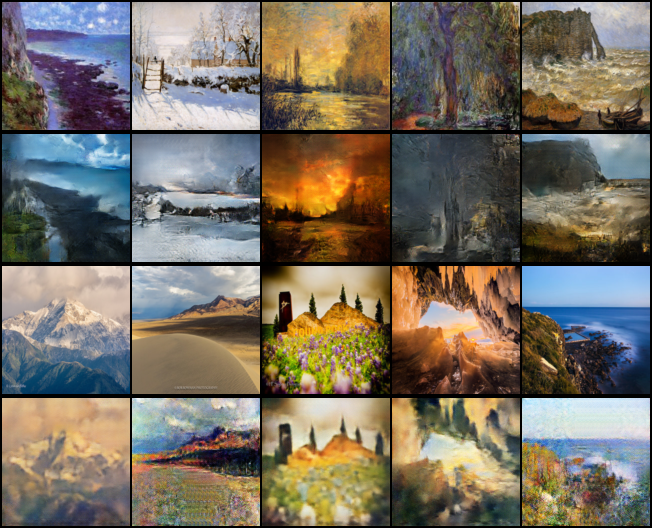

In [51]:
# Сверху вниз: оригинальная картина -> сгенерированное фото -> оригинальное фото -> сгенерированная картина
img = Image.open('generated/112.png').convert('RGB')
img

Здесь приведены примеры изображений, полученных после обучения на 100 эпохах изображений 128х128. Также пробовала обучить до 200 эпох, но результаты получаются хуже.

Для проверки работы генераторов я создала Телеграм-бота: @MonetToPhotoBot. Там можно самостоятельно попробовать преобразовать картину в фото и обратно.